In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install missingno
#import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder,StandardScaler,RobustScaler

In [5]:
def load_application_train():
    data = pd.read_csv("application_train.csv")
    return data

In [6]:
def load():
    data = pd.read_csv("titanic.csv")
    return data

In [13]:
# Aykırı değerleri yakalama

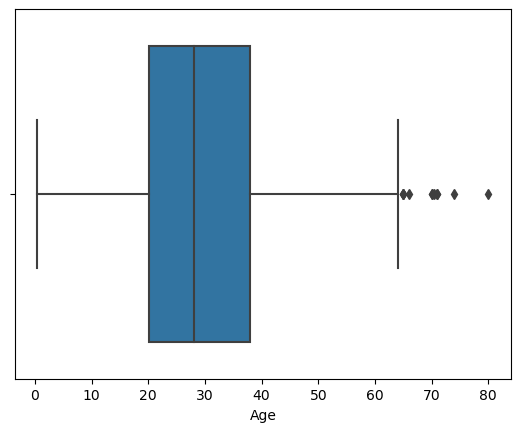

In [8]:
df = load()

sns.boxplot(x=df["Age"])
plt.show()

In [10]:
q1 = df["Age"].quantile(0.25)

In [11]:
q3 = df["Age"].quantile(0.75)

In [12]:
iqr = q3-q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

In [13]:
# Üst sınıra göre Aykırı değerler
df[(df["Age"]<low) | (df["Age"]>up)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,B22,S


In [14]:
# Aykırı değerler indexleri
df[(df["Age"]<low) | (df["Age"]>up)].index

Int64Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [15]:
# Aykırı bir değer var mı yok mu?
df[(df["Age"]<low) | (df["Age"]>up)].any(axis=None)

True

In [16]:
# Aykırı olmayanlar
df[~((df["Age"]<low) | (df["Age"]>up))].any(axis=None)

True

In [17]:
df[(df["Age"]<low)].any(axis=None)

False

In [ ]:
# --------------------------------------------------------- #

In [18]:
# İşlemleri Fonksiyonlaştırma
def outlier_tresholds(df,col_name,q1=.25,q3=.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit , up_limit

In [19]:
# Değerleri eşledik
low,up = outlier_tresholds(df,"Age")

In [20]:
# Aykırı değerleri aldık.
df[(df["Age"]<low) | (df["Age"]>up)].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q


In [22]:
# Var mı yok mu fonksiyonlaştırma
def check_outlier(df,col_name):
    low_limit, up_limit = outlier_tresholds(df,col_name)
    if df[(df[col_name] > up_limit) | (df[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [23]:
check_outlier(df,"Age")

True

In [ ]:
# --------------------------------------------------------- #

In [24]:
dff = load_application_train()

In [25]:
# Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
# Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

# cat_cols, cat_but_car
def grab_col_names(df,cat_th=10,car_th=20):
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and df[col].dtypes != "O"]
    cat_but_car = [col for col in df.columns if df[col].nunique() > cat_th and df[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    #numumerik
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}") # Kategorik
    print(f"num_cols: {len(num_cols)}") # Numerik
    print(f"cat_but_car: {len(cat_but_car)}") # Kategorik ama kardinal
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car

In [26]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [27]:
# İstisanayı çıkardık.
num_cols = [col for col in num_cols if col not in "PassengerId"]

In [28]:
# Numerik değişkenlerde dolaş outlier var mı diye bak.
for col in num_cols:
    print(col,check_outlier(df,col))

Age True
Fare True


In [29]:
# Diğer dataframe e baktık
cat_cols, num_cols, cat_but_car = grab_col_names(dff)

Observations: 307511
Variables: 122
cat_cols: 53
num_cols: 67
cat_but_car: 2
num_but_cat: 39


In [30]:
num_cols = [col for col in num_cols if col not in "SK_ID_CURR"]

In [58]:
for col in num_cols:
    print(col,check_outlier(dff,col))

CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG True
FLOORSMIN_AVG True
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FLOORSMAX_MODE True
FLOORSMIN_MODE True
LANDAREA_MODE True
LIVINGAPARTMENTS_MODE True
LIVINGAREA_MODE True
NONLIVINGAPARTMENTS_MODE True
NONLIVINGAREA_MODE True
APARTMENTS_MEDI True
BASEMENTAREA_MEDI 

In [1]:
# --------------------------------------------------------- #

In [34]:
# Aykırı değerlere kendilerinden erişmek
def grab_outliers(df,col_name,index=False):
    low,up = outlier_tresholds(df,col_name)
    
    if df[((df[col_name]<low) | (df[col_name]>up))].shape[0] > 10:
        print(df[((df[col_name]<low) | (df[col_name]>up))].head())
    else:
        print(df[((df[col_name]<low) | (df[col_name]>up))])
        
    if index:
        outlier_index = df[((df[col_name]<low) | (df[col_name] > up))].index
        return outlier_index

In [35]:
grab_outliers(df,"Age")
# İndex Bilgisi
# age_index = grab_outliers(df,"Age",True)

     PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male   
96            97         0       1       Goldschmidt, Mr. George B  male   
116          117         0       3            Connors, Mr. Patrick  male   
280          281         0       3                Duane, Mr. Frank  male   

      Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   66.0      0      0  C.A. 24579  10.5000   NaN        S  
54   65.0      0      1      113509  61.9792   B30        C  
96   71.0      0      0    PC 17754  34.6542    A5        C  
116  70.5      0      0      370369   7.7500   NaN        Q  
280  65.0      0      0      336439   7.7500   NaN        Q  


In [36]:
# --------------------------------------------------------- #

In [38]:
# Aykırı Değer Probşemini Çözme
# Silme
    
low,up = outlier_tresholds(df,"Fare")

# Üst sınır üstündekiler ve alt sınır altındakileri almadık.
df[~((df["Fare"]<low) | (df["Fare"]>up))].shape

(775, 12)

In [39]:
def remove_outlier(df,col_name):
    low_limit, up_limit = outlier_tresholds(df,col_name)
    df_without_outliers = df[~((df[col_name]<low_limit) | (df[col_name]>up_limit))]
    return df_without_outliers

In [40]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
# Aykırı
num_cols = [col for col in num_cols if col not in "PassengerId"]

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [41]:
# Silme işlemi
for col in num_cols:
    new_df = remove_outlier(df,col)

In [43]:
# Silindi.
new_df.shape

(775, 12)

In [45]:
# Baskılama Yöntemi
low, up = outlier_tresholds(df,"Fare")

In [46]:
df[((df["Fare"]<low) | (df["Fare"]>up))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
...,...,...,...,...,...,...,...,...,...,...,...,...
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.5500,NaN,S
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1,0,17453,89.1042,C92,C
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S


In [48]:
df.loc[((df["Fare"]<low) | (df["Fare"]>up)),"Fare"]

1       71.2833
27     263.0000
31     146.5208
34      82.1708
52      76.7292
         ...   
846     69.5500
849     89.1042
856    164.8667
863     69.5500
879     83.1583
Name: Fare, Length: 116, dtype: float64

In [50]:
# Up limitleri artık aykırıların yeni değerleri
df.loc[(df["Fare"]>up),"Fare"] = up

In [52]:
def replace_with_thresholds(df,variable):
    low_limit, up_limit = outlier_tresholds(df,variable)
    df.loc[(df[variable]<low_limit),variable] = low_limit
    df.loc[(df[variable]>up_limit),variable] = up_limit

In [53]:
for col in num_cols:
    replace_with_thresholds(df,col)

In [55]:
# Aykırı değer kalmadı
for col in num_cols:
    print(col,check_outlier(df,col))

Age False
Fare False


In [ ]:
# --------------------------------------------------------- #

In [ ]:
# Recap - Özet

# Veriyi okuduk.
df = load()

outlier_tresholds(df,"Age")

# Outlier var mı yok mu?
check_outlier(df,"Age")
grab_outliers(df,"Age",index=True)

# Silelim 
remove_outlier(df,"Age")

#Baskılayalım-Değiştirelim
replace_with_thresholds(df,"Age")

# Tekrar gözlemledik ve kurtulduk
check_outlier(df,"Age")